### Recreate the findings from `Cultural influences on word meanings revealed through large-scale semantic alignment`

Article can be found [here](https://www.nature.com/articles/s41562-020-0924-8)

What we want: 
- compare how "close" a synthetic language is to real english and real source language. 

What we have:
- across different settings (real, synthetic)
    - across different languages 
        - the sim approach developed in paper above. 


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt


In [ ]:
data_source = 'concreteness' # concreteness, NorthErualex_concepts
data_dir = f'../data/{data_source}/similarity/'
settings = ['synthetic_synthetic', 'real_real', 'synthetic_real']
langs = ['en','fr','de','ja', 'ru','et','hi']
model_name = 'Meta-Llama-3-1-70B-Instruct-htzs' # 'Meta-Llama-3-1-8B-Instruct-nwxcg', 'Meta-Llama-3-1-70B-Instruct-htzs'
pearsons = []

for setting in settings:
    for lang1 in langs:
        for lang2 in langs: 
            if (lang1 == lang2) & (setting != 'synthetic_real'):
                continue
            
            data_path = f'{data_dir}{model_name}/{setting}/{lang1}_{lang2}.csv'
            try: 
                df = pd.read_csv(data_path)
                # pearson correlation btwn sim and tr_sim
                df.dropna(inplace=True)
                pearson = df['sim'].corr(df['tr_sim'], method='pearson')
                pearsons.append({
                    'lang1': lang1,
                    'lang2': lang2,
                    'setting': setting,
                    'pearson': pearson
                })
            except Exception as e:
                print('no data for ', data_path)
                print(e)

          src_word     tr_src_word      tar_word     tr_tar_word       sim  \
877380       woven           tissé        weaved           tissé  0.739978   
590840  naturalist     naturaliste  naturalistic     naturaliste  0.814267   
167436  civilizing       civiliser      civilize       civiliser  0.841037   
877312       woven           tissé          wove           tissé  0.932510   
6112       academy        académie      academia        académie  0.559228   
...            ...             ...           ...             ...       ...   
102601    blastoff  être mis à feu         camel         chameau  0.609856   
137056       camel         chameau      blastoff  être mis à feu  0.609856   
768608       smelt         éperlan         aloft         en haut  0.766350   
31704        aloft         en haut         smelt         éperlan  0.766350   
830504     torpedo        torpille         aloft         en haut  0.678485   

          tr_sim  
877380  1.000000  
590840  1.000000  
167436

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


           src_word tr_src_word                tar_word tr_tar_word       sim  \
285009  démographie      人口統計学的       démographiquement      人口統計学的  0.759732   
850368     tourisme          観光             touristique          観光  0.817145   
159439      classer        分類する  classer par catégories        分類する  0.810707   
642182  philosopher          哲学           philosophique          哲学  0.805945   
877245       utopie       ユートピア                utopique       ユートピア  0.796928   
...             ...         ...                     ...         ...       ...   
195514      contenu       コンテンツ                    jeté      スローされた  0.562131   
41495        annexe          付録                    jeté      スローされた  0.534520   
909459       éduqué      教育を受けた                    jeté      スローされた  0.567988   
668378        posté       投稿された                    jeté      スローされた  0.583282   
509437      lecture          再生                    jeté      スローされた  0.568207   

          tr_sim  
285009  

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


                    src_word            tr_src_word        tar_word  \
768491               salaire       заработная плата    les salaires   
590666                 notre                    наш      les notres   
58062                arrière                  назад  vers l'arrière   
28237   allaitement maternel  грудное вскармливание        allaiter   
882169        vers l'arrière                  назад         arrière   
...                      ...                    ...             ...   
102592                bonnet                шапочка          écuyer   
820442          sur la photo                на фото        démanger   
820381          sur la photo                на фото         manteau   
820440          sur la photo                на фото         bouchon   
520064                loquet                защелка          écuyer   

                  tr_tar_word       sim    tr_sim  
768491       заработная плата  0.682469  1.000000  
590666                    наш  0.615001  1.

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


                src_word  tr_src_word          tar_word  tr_tar_word  \
81826     bande dessinée        हास्य            humour        हास्य   
434476         injurieux     अपमानजनक         dénigrant     अपमानजनक   
878079        ésotérique        गुप्त         cryptique        गुप्त   
333838       faisabilité      साध्यता     praticabilité      साध्यता   
635907     praticabilité      साध्यता       faisabilité      साध्यता   
...                  ...          ...               ...          ...   
839329  vieille sorcière         डायन       boutonnière         फंदा   
101511       boutonnière         फंदा  vieille sorcière         डायन   
828382        uniformité        वर्दी        logistique         साजो   
655044       prématurité      कुसमयता     amoureusement  आशिक मिजाजी   
33224      amoureusement  आशिक मिजाजी       prématurité      कुसमयता   

             sim    tr_sim  
81826   0.556607  1.000000  
434476  0.651055  1.000000  
878079  0.667324  1.000000  
333838  0.819216  1

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


            src_word tr_src_word      tar_word   tr_tar_word       sim  \
194901            ei         egg            ei           egg      -inf   
393051            hm        ahem            hm          ahem      -inf   
153494            bö      squall            bö        squall      -inf   
129491            bh         bra            bh           bra      -inf   
330168  geozentrisch  geocentric  egozentrisch    egocentric  0.999990   
...              ...         ...           ...           ...       ...   
853934       vanille     vanilla        klemme         clamp  0.574619   
759339         spule        coil   elektroskop  electroscope  0.201092   
456000        klemme       clamp         matte           mat  0.710086   
540915         matte         mat        klemme         clamp  0.710086   
759343         spule        coil     abkürzung      shortcut  0.237680   

          tr_sim  
194901  1.000000  
393051  1.000000  
153494  1.000000  
129491  1.000000  
330168  0.999946

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


              src_word tr_src_word        tar_word    tr_tar_word       sim  \
678797        steingut        grès       sandstein           grès  0.813491   
309124         gewebte       tissé          gewebt          tissé  0.871908   
833357    wissenschaft    académie        akademie       académie  0.626524   
309047          gewebt       tissé         gewebte          tissé  0.871908   
315724    gleichsetzen   assimiler    assimilieren      assimiler  0.588640   
...                ...         ...             ...            ...       ...   
319474            gral       graal      offenbaren      divulguer  0.566886   
319549            gral       graal         aalwurm     anguillule  0.569510   
133            aalwurm  anguillule            gral          graal  0.569510   
821567  weit hergeholt     farfelu  entgegenwirken   contrecarrer  0.638304   
531661            oben     en haut         gehoben  haut de gamme  0.607767   

          tr_sim  
678797  1.000000  
309124  1.000

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


              src_word tr_src_word        tar_word tr_tar_word       sim  \
818346    unterbrochen       中断された     abgebrochen       中断された  0.851480   
781746     touristisch          観光       tourismus          観光  0.657436   
497293    lautsprecher       スピーカー          redner       スピーカー  0.589353   
781656       tourismus          観光     touristisch          観光  0.657436   
441943  klassifizieren        分類する  kategorisieren        分類する  0.652436   
...                ...         ...             ...         ...       ...   
338487        geworfen      スローされた       angezeigt       表示される  0.608475   
467993         konzern        株式会社        geworfen      スローされた  0.548427   
338445        geworfen      スローされた     abstrahiert      抽象化された  0.624367   
338499        geworfen      スローされた          mollig      ふわふわした  0.620086   
338464        geworfen      スローされた       eventuell        最終的な  0.602795   

          tr_sim  
818346  1.000000  
781746  1.000000  
497293  1.000000  
781656  1.0

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


           src_word tr_src_word        tar_word     tr_tar_word       sim  \
693638  schmollmund     гримаса        grimasse         гримаса  0.684602   
818149        unser         наш          unsere             наш  0.809668   
351815     grimasse     гримаса     schmollmund         гримаса  0.684602   
818304       unsere         наш           unser             наш  0.809668   
954530      ökologe      эколог  umweltschützer          эколог  0.713828   
...             ...         ...             ...             ...       ...   
204546      elefant        слон           waise          сирота  0.501570   
204614      elefant        слон        paradies             рай  0.462254   
3008     abgebildet     на фото       weichtier         моллюск  0.580774   
2983     abgebildet     на фото         muschel         моллюск  0.600869   
2949     abgebildet     на фото    holzschuppen  дровяной сарай  0.597885   

          tr_sim  
693638  1.000000  
818149  1.000000  
351815  1.000000  

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


                 src_word     tr_src_word           tar_word tr_tar_word  \
425408        koeffizient            गुणक      multiplikator        गुणक   
875902     zauberkünstler         जादूगार           zauberer     जादूगार   
85632       befahrbarkeit         साध्यता   durchführbarkeit     साध्यता   
467350              lange            लंबा               lang        लंबा   
875693           zauberer         जादूगार     zauberkünstler     जादूगार   
...                   ...             ...                ...         ...   
511911          miniserie    लघु श्रृंखला              tonne          टन   
657497  schokoladenkuchen         ब्राउनी             fühler        मूंछ   
276413             fühler            मूंछ  schokoladenkuchen     ब्राउनी   
153233    demoralisierung  आचारभ्रष्टीकरण        anstrengung   प्रयास है   
725785             taille             कमर              motte         कीट   

             sim    tr_sim  
425408  0.781236  1.000000  
875902  0.680874  1.000000  


/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


       src_word tr_src_word tar_word tr_tar_word       sim    tr_sim
928733       美徳      virtue       美徳      virtue      -inf  1.000000
567238       孤児      orphan       孤児      orphan      -inf  1.000000
633943       忠誠     loyalty       忠誠     loyalty      -inf  1.000000
724191       暗号      cipher       暗号      cipher      -inf  1.000000
520580       回答      answer       回答      answer      -inf  1.000000
...         ...         ...      ...         ...       ...       ...
182356      チゼル      chisel      コイル        coil  0.245248 -0.441625
114401      コイル        coil      チゼル      chisel  0.245248 -0.441625
56879       イタチ      weasel     クランプ       clamp  0.271552 -0.461662
259000     ブラブラ    browbeat      コイル        coil  0.296681 -0.462538
114405      コイル        coil     ブラブラ    browbeat  0.296681 -0.462538

[818671 rows x 6 columns]


/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


       src_word     tr_src_word tar_word     tr_tar_word       sim    tr_sim
473124       嫌な         dégoûté       嫌な         dégoûté      -inf  1.000000
860946       記号      signifiant       記号      signifiant      -inf  1.000000
630071        杉           cèdre        杉           cèdre      -inf  1.000000
519260        弦           corde        弦           corde      -inf  1.000000
851704       規律      discipliné       規律      discipliné      -inf  1.000000
...         ...             ...      ...             ...       ...       ...
962008     飛び立つ  être mis à feu      イナゴ         criquet  0.268199 -0.371400
51246       イナゴ         criquet     飛び立つ  être mis à feu  0.268199 -0.371400
46655      アロフト         en haut      夜明け            aube  0.310967 -0.423380
387250    勇気づける      s'abstenir     グレイル           graal  0.208084 -0.457193
92219      グレイル           graal    勇気づける      s'abstenir  0.208084 -0.457193

[710539 rows x 6 columns]
no data for  ../data/concreteness/similarity/Meta

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


        src_word            tr_src_word tar_word            tr_tar_word  \
827989        甘い              приторный       甘い              приторный   
751570        母乳  грудное вскармливание       母乳  грудное вскармливание   
1070896       集塊          нагромождение       集塊          нагромождение   
909865         緑                 зелень        緑                 зелень   
807113        熟考             созерцание       熟考             созерцание   
...          ...                    ...      ...                    ...   
93678     キャットマン                скотник    ストーンズ             под кайфом   
157256     ストーンズ             под кайфом   キャットマン                скотник   
212027      ハンター                охотник    ストーンズ             под кайфом   
299237       メタン                  метан     描かれた                на фото   
682285      描かれた                на фото      メタン                  метан   

              sim    tr_sim  
827989       -inf  1.000000  
751570       -inf  1.000000  
1070896  

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


       src_word     tr_src_word tar_word     tr_tar_word       sim    tr_sim
521915       嫌な          अप्रिय       嫌な          अप्रिय      -inf  1.000000
836159        約     के बारे में        約     के बारे में      -inf  1.000000
893434        蚊           मच्छर        蚊           मच्छर      -inf  1.000000
793921       皮質      प्रांतस्था       皮質      प्रांतस्था      -inf  1.000000
794362       盗作  साहित्यिक चोरी       盗作  साहित्यिक चोरी      -inf  1.000000
...         ...             ...      ...             ...       ...       ...
439750     半球形の         अर्धगोल    フード付き         नकाबपोश  0.203069 -0.410154
237936    フード付き         नकाबपोश     半球形の         अर्धगोल  0.203069 -0.410154
963273     送信する           भेजना     侵入する          घुसपैठ  0.206878 -0.411319
368224     侵入する          घुसपैठ     送信する           भेजना  0.206878 -0.411319
93568   クライマックス             चरम     仕上がり         कारीगरी  0.577126 -0.439778

[751004 rows x 6 columns]


/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


no data for  ../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/ru_en.csv
Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.
                 src_word    tr_src_word           tar_word    tr_tar_word  \
413186         натуралист    naturaliste  натуралистический    naturaliste   
621943       приравнивать      assimiler          усваивать      assimiler   
413311  натуралистический    naturaliste         натуралист    naturaliste   
836503           уродство        horreur          омерзение        horreur   
621745        приподнятый          élevé           поднятый          élevé   
...                   ...            ...                ...            ...   
396286               мясо          moi à             молоко           lait   
385995             молоко           lait               мясо          moi à   
803276            торпеда       torpille             наверх        en haut   
478274              

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


              src_word tr_src_word         tar_word tr_tar_word       sim  \
193112  демографически      人口統計学的  демографическое      人口統計学的  0.847277   
929258         туристы          観光           туризм          観光  0.713876   
929018          туризм          観光          туристы          観光  0.713876   
773535     регистрация          登録          регистр          登録  0.788546   
974231     философский          哲学  философствовать          哲学  0.693449   
...                ...         ...              ...         ...       ...   
24273       аппликатор     アプリケーター    истолкователь       建設主義者  0.572577   
368970         костюмы      コスチューム        выброшены      スローされた  0.567339   
130164       выброшены      スローされた   подсознательно     無意識のうちに  0.596099   
130185       выброшены      スローされた     картирование      チャート作成  0.590138   
130094       выброшены      スローされた      развернутый  折りたたまれていない  0.609690   

          tr_sim  
193112  1.000000  
929258  1.000000  
929018  1.000000  

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


              src_word   tr_src_word        tar_word   tr_tar_word       sim  \
899305  уничижительный      अपमानजनक  оскорбительный      अपमानजनक  0.856679   
534985  оскорбительный      अपमानजनक  уничижительный      अपमानजनक  0.856679   
664356      признанный  स्वीकार किया         признал  स्वीकार किया  0.692254   
949081         чародей       जादूगार       чародейка       जादूगार  0.504977   
675365      пробуждать         जगाना          будить         जगाना  0.615244   
...                ...           ...             ...           ...       ...   
126057        выделены        निशाना        задушены           लाद  0.622543   
178774   дезориентация         भटकाव   желательность         इच्छा  0.690922   
968978    шунтирование      ब्रिजिंग  разбрызгивание         फुहार  0.789853   
706544  разбрызгивание         फुहार    шунтирование      ब्रिजिंग  0.789853   
479395   несовершенный        अपूर्ण  уполномоченный        आयुक्त  0.711189   

          tr_sim  
899305  1.000000  
5

/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


          src_word tr_src_word   tar_word tr_tar_word       sim    tr_sim
929499          वू         woo         वू         woo      -inf  1.000000
1112686         है        have         है        have      -inf  1.000000
557863          पब         pub         पब         pub      -inf  1.000000
202936          का          of         का          of      -inf  1.000000
342550          चौ        chow         चौ        chow      -inf  1.000000
...            ...         ...        ...         ...       ...       ...
295495        गोंद        glue  शिष्टाचार        tact  0.303118 -0.427725
441027       तिरछा       askew      कुंडल        coil  0.234798 -0.449850
224377       कुंडल        coil      तिरछा       askew  0.234798 -0.449850
457099       दबाना       clamp  ट्रिअमिसु    tiramisu  0.262237 -0.568599
407404   ट्रिअमिसु    tiramisu      दबाना       clamp  0.262237 -0.568599

[1112515 rows x 6 columns]


/home/vv7118/miniconda3/envs/mech-int/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


##### Hypothesis 1: on average, there is more similarity in the synthetic-synthetic setting than real-real setting.

First, we consider a simple exploration. To what extent does the synthetic distribution converge to one representation.

- what is the average correlation between langs in different settings. 
-> expect the correlation to be most central in synthetic

- do the norm analysis

- do the synth representations converge to one mode? 



In [3]:
df = pd.DataFrame(pearsons)
df_temp = df[df['lang1'] != df['lang2']]
df_temp['id'] = df_temp.apply(lambda x: '_'.join(sorted([x['lang1'], x['lang2']])), axis=1)

plotting_data = df_temp.groupby(['id', 'setting'])['pearson'].mean().unstack()

/tmp/ipykernel_3044035/4094490215.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['id'] = df_temp.apply(lambda x: '_'.join(sorted([x['lang1'], x['lang2']])), axis=1)


In [4]:
plotting_data['has_eng'] = plotting_data.index.str.contains('en')
plotting_data.groupby('has_eng').mean()

setting,real_real,synthetic_real,synthetic_synthetic
has_eng,,,
False,NaN,NaN,NaN
True,0.116192,0.130103,0.163282


/tmp/ipykernel_2481263/3029792413.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plotting_data.index, rotation=90)


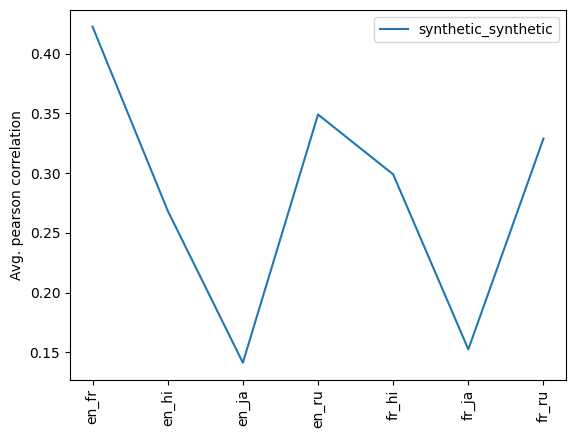

In [ ]:
import os 
fig, ax = plt.subplots()

ax.plot(plotting_data.index, plotting_data['real_real'], label='real_real')
ax.plot(plotting_data.index, plotting_data['synthetic_synthetic'], label='synthetic_synthetic')
ax.plot(plotting_data.index, plotting_data['synthetic_real'], label='synthetic_real')
ax.set_xticklabels(plotting_data.index, rotation=90)
ax.set_ylabel('Avg. pearson correlation')
plt.legend()
img_save_path = f'../visuals/{data_source}/{model_name}/'
os.makedirs(img_save_path, exist_ok=True)
plt.savefig(f'../visuals/{data_source}/{model_name}/pearson_correlation.jpg', dpi=300, bbox_inches='tight')

**Conclusion.** The fact that real-real always below synthetic-synthetic implies representations more centralized in synthetic space. 

##### Hypothesis 2: synthetic-real will be closer to english across all langs than their own.

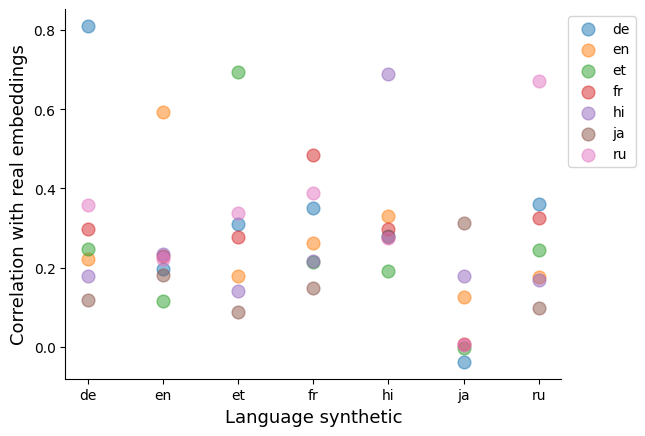

In [ ]:
sr = df[df['setting'] == 'synthetic_real']

sr_pivot = sr.pivot(index='lang1', columns='lang2', values='pearson')


cols = sr_pivot.columns

fig, ax = plt.subplots()
for col in cols:
    sr_pivot[col] 
    ax.scatter(sr_pivot.index, sr_pivot[col], label=col, alpha=0.5, s=85)

ax.spines[['right','top']].set_visible(False)
ax.set_xlabel('Language synthetic', fontsize=13)
ax.set_ylabel("Correlation with real embeddings", fontsize=13)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.savefig(f'../visuals/{data_source}/{model_name}/synthetic_real_correlation_by_lang.jpg', dpi=300, bbox_inches='tight')


**Normalize the scores by the real-real similarity.** It's feasible, that the languages are not similar. Surprise. So we should adjust by there baseline similarity in the real-real case. 

TODO: consider if we should use the real Wikipedia embeddings to get an estimate of this. 


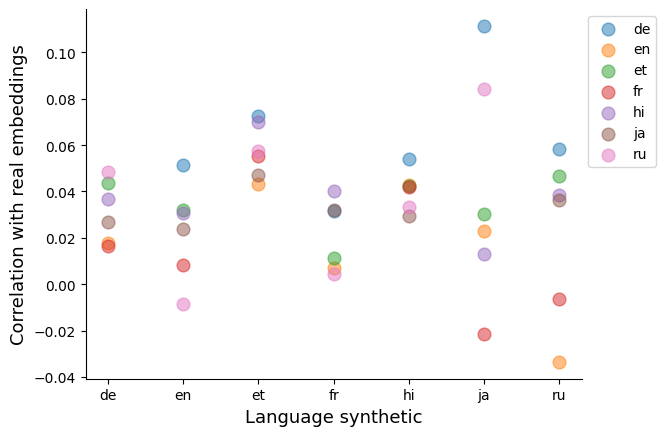

In [ ]:
sr = df[df['setting'] == 'synthetic_real']
rr = df[df['setting'] == 'real_real']

sr_m = sr.merge(rr, on=['lang1', 'lang2'], suffixes=('_sr', '_rr'))
sr_m['diff'] = sr_m['pearson_sr'] - sr_m['pearson_rr']

sr_m_pivot = sr_m.pivot(index='lang1', columns='lang2', values='diff')


cols = sr_m_pivot.columns

fig, ax = plt.subplots()
for col in cols:
    sr_pivot[col] 
    ax.scatter(sr_m_pivot.index, sr_m_pivot[col], label=col, alpha=0.5, s=85)

ax.spines[['right','top']].set_visible(False)
ax.set_xlabel('Language synthetic', fontsize=13)
ax.set_ylabel("Correlation with real embeddings", fontsize=13)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.savefig(f'../visuals/{data_source}/{model_name}/synthetic_real_correlation_by_lang_diffed.jpg', dpi=300, bbox_inches='tight')


##### Hypothesis 3: There are structural patterns in terms of how languages differ.

- Compare similarity across different semantic categories. 

In [1]:
cluster_path = '../data/NorthErualex_concepts/semantic_domain_to_word_forms.csv'

cluster_df = pd.read_csv(cluster_path)

lid_lid_mapping = {
    'ekk': 'et',
    'hin': 'hi',
    'rus': 'ru',
    'eng': 'en',
    'fra': 'fr',
    'jpn': 'ja',
    'deu': 'de'
}

cluster_df['language_id'] = cluster_df['language_id'].map(lid_lid_mapping)

NameError: name 'pd' is not defined

,src_word,tr_src_word,tar_word,tr_tar_word,sim,tr_sim
0,-आना,-आना,-आना,-आना,1.000000,1.000000
1,-आना,-आना,पुराना,पुराना,0.295109,0.295109
2,-आना,-आना,चमड़ा,चमड़ा,0.291771,0.291771
3,-आना,-आना,स्वप्न,स्वप्न,0.265288,0.265288
4,-आना,-आना,जानु,जानु,0.258034,0.258034
...,...,...,...,...,...,...
134095,होशियार,होशियार,अपरिचित,अपरिचित,0.143959,0.143959
134096,होशियार,होशियार,रंजीदा,रंजीदा,0.143754,0.143754
134097,होशियार,होशियार,गुर्राना,गुर्राना,0.142995,0.142995
134098,होशियार,होशियार,बाज़ू,बाज़ू,0.142835,0.142835


In [ ]:
data_source = 'NorthErualex_concepts' # concreteness, NorthErualex_concepts
data_dir = f'../data/{data_source}/similarity/'
settings = ['synthetic_synthetic', 'real_real', 'synthetic_real']
langs = ['en','fr','de','ja', 'ru','et','hi']
model_name = 'Meta-Llama-3-1-8B-Instruct-nwxcg' # 'Meta-Llama-3-1-8B-Instruct-nwxcg', 'Meta-Llama-3-1-70B-Instruct-htzs'
pearsons_2 = []

for setting in settings:
    for lang1 in langs:
        for lang2 in langs: 
            if (lang1 == lang2) & (setting != 'synthetic_real'):
                continue
            
            data_path = f'{data_dir}{model_name}/{setting}/{lang1}_{lang2}.csv'
            try: 
                df = pd.read_csv(data_path)
                cluster_df_temp = cluster_df[cluster_df['language_id'] == lang1]
                df = df.merge(cluster_df, left_on='src_word', right_on='word_form')
                # pearson correlation btwn sim and tr_sim
                gps = df.groupby('semantic_domain')
                for name, gp in gps:
                    pearson = gp['sim'].corr(df['tr_sim'], method='pearson')
                    pearsons_2.append({
                        'lang1': lang1,
                        'lang2': lang2,
                        'setting': setting,
                        'pearson': pearson,
                        'semantic_domain': name,
                    })
            except Exception as e:
                print('no data for ', data_path)
                print(e)

no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_synthetic/en_fr.csv
name 'cluster_df' is not defined
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_synthetic/en_de.csv
name 'cluster_df' is not defined
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_synthetic/en_ja.csv
name 'cluster_df' is not defined
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_synthetic/en_ru.csv
name 'cluster_df' is not defined
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_synthetic/en_et.csv
name 'cluster_df' is not defined
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_synthetic/en_hi.csv
name 'cluster_df' is not defined
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_syn

In [25]:
df2 = pd.DataFrame(pearsons_2)

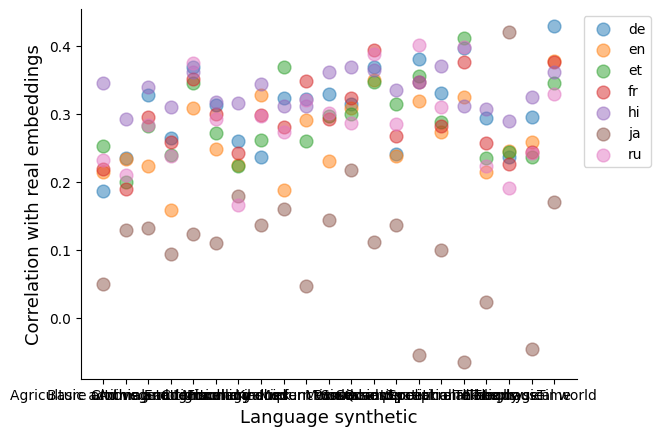

In [ ]:
sr = df2[df2['setting'] == 'synthetic_real']

sr = sr.groupby(['lang1', 'semantic_domain'])['pearson'].mean().reset_index()

sr_pivot = sr.pivot(index='semantic_domain', columns='lang1', values='pearson')


cols = sr_pivot.columns

fig, ax = plt.subplots()
for col in cols:
    sr_pivot[col] 
    ax.scatter(sr_pivot.index, sr_pivot[col], label=col, alpha=0.5, s=85)

ax.spines[['right','top']].set_visible(False)
ax.set_xlabel('Language synthetic', fontsize=13)
ax.set_ylabel("Correlation with real embeddings", fontsize=13)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
# plt.savefig(f'../visuals/north_euralex_concepts/{model_name}/synthetic_real_correlation_by_lang.jpg', dpi=300, bbox_inches='tight')
